In [1]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from pathlib import Path
from pydub import AudioSegment
import librosa
from tensorflow.keras.utils import plot_model
import soundfile as sf
import shutil
from PIL import Image


import shap
import gc
from collections import Counter
from pydub.silence import detect_silence
import librosa.display
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

import json
from PIL import Image
import shutil
import csv


# DATA_DIR = pathlib.Path('data')
# TEST_DIR = pathlib.Path('data/new_test')

# Globale Pfade für die Daten
ROOT_DIR = Path('../').resolve()  # Hauptverzeichnis
# ZIP_DIR = ROOT_DIR / 'data'  # Ordner, der die ZIP-Dateien enthält
UNZIP_DIR = ROOT_DIR / 'Unzipped_Data_Picture'  # Zielordner für entpackte Dateien
TEST_DIR = ROOT_DIR / UNZIP_DIR / 'new_test'

c:\Users\prett\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_zip(zip_path, extract_to):
    zip_path_str = str(zip_path)
    
    if not zip_path_str.endswith('.zip'):
        zip_path_str += '.zip'
    
    zip_file_path = pathlib.Path(zip_path_str)
    
    folder_name = zip_file_path.stem 
    target_folder = pathlib.Path(extract_to) / folder_name
    
    if target_folder.exists():
        print(f"Das Verzeichnis {target_folder} existiert bereits. Überspringe das Extrahieren.")
    else:
        if zip_file_path.exists():
            print(f"Extrahiere die Zip-Datei {zip_file_path} nach {extract_to}.")
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"Zip-Datei {zip_file_path} erfolgreich extrahiert.")
        else:
            print(f"Die Zip-Datei {zip_file_path} existiert nicht.")

def rename_audio_files(root_path):
    for root, dirs, files in os.walk(root_path):
        parent_folder = os.path.basename(root)
        for file in files:
            if not file.startswith(f"{parent_folder}_"):
                if file.endswith(('.wav', '.mp3')):  
                    
                    old_file_path = os.path.join(root, file)
                    new_file_name = f"{parent_folder}_{file}"
                    new_file_path = os.path.join(root, new_file_name)
                        
                    os.rename(old_file_path, new_file_path)
        print(f"renaming of {root_path}/{parent_folder} complete")

In [3]:
def normalize_audio_length(input_dir):
    output_dir = input_dir.parent / f"{input_dir.name}_normalized"
    if output_dir.exists():
        print(f"Überspringe Verarbeitung, da {output_dir} bereits existiert.")
        return output_dir
    os.makedirs(output_dir, exist_ok=True)
    
    max_length = 0
    audio_files = []
    
    # Bestimme die längste Datei
    for subdir, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".wav"):
                input_path = Path(subdir) / file
                audio = AudioSegment.from_file(input_path)
                duration = len(audio)
                max_length = max(max_length, duration)
                audio_files.append((input_path, audio))
    
    print(f"Maximale Länge: {max_length / 1000} Sekunden")
    
    # Normalisiere alle Dateien auf die maximale Länge
    for input_path, audio in audio_files:
        padded_audio = audio + AudioSegment.silent(duration=max_length - len(audio))
        
        relative_path = input_path.parent.relative_to(input_dir)
        target_dir = output_dir / relative_path
        os.makedirs(target_dir, exist_ok=True)
        output_path = target_dir / input_path.name
        
        padded_audio.export(output_path, format="wav")
        print(f"Processed {input_path.name}: expanded to {max_length / 1000} seconds")
    
    print(f"Processing complete. Normalized files saved in {output_dir}")
    return output_dir

In [4]:
def process_audio_file(audio_file, input_dir, output_dir, n_mels, fmin, fmax):
    """
    Diese Funktion verarbeitet eine einzelne Audiodatei und berechnet das Mel-Spektrogramm.
    """
    # Relativer Pfad zur Eingabedatei
    relative_path = audio_file.relative_to(input_dir)
    
    # Zielpfad basierend auf der ursprünglichen Ordnerstruktur
    target_dir = output_dir / relative_path.parent
    target_dir.mkdir(parents=True, exist_ok=True)
    
    # Lade die Audiodatei mit librosa
    y, sr = librosa.load(audio_file, sr=44100)

    # Berechne das Mel-Spektrogramm
    # padding = 1024
    # y = np.pad(y, (padding, padding), mode='constant')
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)

    # Konvertiere das Mel-Spektrogramm in dB (logarithmische Skala)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Rückgabe der Daten ohne das Plotten
    return relative_path, mel_spectrogram, sr, target_dir, audio_file.stem

def generate_mel_spectrograms_with_structure(input_dir, output_dir, n_mels=256, fmin=20, fmax=44100, batch_size=25, square = False):
    """
    Optimierte Funktion für die Verarbeitung von Mel-Spektrogrammen:
    1. Berechnung wird parallelisiert.
    2. Ergebnisse werden sequentiell geplottet, um Thread-Sicherheitsprobleme zu vermeiden.
    3. Batches werden verwendet, um den Speicherverbrauch zu kontrollieren.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    # Überprüfen, ob die Ordnerstruktur bereits existiert
    if output_dir.exists() and any(output_dir.rglob("*.png")):
        print(f"Überspringe Verarbeitung, da {output_dir} bereits Mel-Spektrogramme enthält.")
        return

    # Liste der .wav-Dateien im input_dir
    audio_files = list(input_dir.rglob("*.wav"))

    if not audio_files:
        print("Keine Audiodateien gefunden.")
        return

    total_files = len(audio_files)
    print(f"{total_files} Audiodateien gefunden. Verarbeitung startet.")

    # Verarbeite die Dateien in Batches
    for batch_start in range(0, total_files, batch_size):
        batch_files = audio_files[batch_start:batch_start + batch_size]
        gc.collect()
        print(f"Verarbeite Batch {batch_start // batch_size + 1} von {total_files // batch_size + 1}")

        # Parallele Berechnung der Mel-Spektrogramme
        results = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(process_audio_file, audio_file, input_dir, output_dir, n_mels, fmin, fmax)
                for audio_file in batch_files
            ]
            for future in concurrent.futures.as_completed(futures):
                results.append(future.result())

        # Sequentielles Plotten und Speichern
        for relative_path, mel_spectrogram_db, sr, target_dir, audio_file_stem in results:
            mel_spectrogram_path = target_dir / f"{audio_file_stem}_mel_spectrogram.png"

            # Überspringen, wenn das Spektrogramm bereits existiert
            if mel_spectrogram_path.exists():
                print(f"Spektrogramm {mel_spectrogram_path} existiert bereits. Überspringen.")
                continue

            try:
                # Erstelle das Bild des Mel-Spektrogramms
                if square:
                    plt.figure(figsize=(2, 2))
                    librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap='magma', fmin=fmin, fmax=fmax)
                    plt.axis('off')

                # Speichern des Bildes als PNG
                    plt.savefig(mel_spectrogram_path, bbox_inches='tight', pad_inches=0, dpi=300)
                    plt.close()
                    print(f"{batch_start // batch_size + 1} von {total_files // batch_size + 1}__Mel-Spektrogramm für {audio_file_stem} gespeichert in {mel_spectrogram_path}")
                else:
                    height = 2000  # Höhe in Pixel
                    width = height * 30  # Breite als Vielfaches der Höhe
                    dpi = 100  # Auflösung
                    figsize = (width / dpi, height / dpi)

                    # Erstelle die Figure mit exakt berechneter Größe
                    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, frameon=False)

                    # Spektrogramm anzeigen
                    librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap='magma', fmin=fmin, fmax=fmax)
                    ax.set_axis_off()

                    # Speichern des Bildes ohne Padding oder Verzerrung
                    plt.savefig(mel_spectrogram_path, bbox_inches='tight', pad_inches=0, dpi=dpi)
                    plt.close(fig)
                    print(f"{batch_start // batch_size + 1} von {total_files // batch_size + 1}__Mel-Spektrogramm für {audio_file_stem} gespeichert in {mel_spectrogram_path}")

            except Exception as e:
                print(f"Fehler beim Plotten von {audio_file_stem}: {e}")
            finally:
                # Speicher freigeben
                del mel_spectrogram_db
                # gc.collect()
                # print("batch complete")

    print(f"Alle Mel-Spektrogramme gespeichert in {output_dir}")

In [5]:
def split_spectrogram(image_path, output_dir):
    """
    Schneidet ein Spektrogramm in gleich große Quadrate.
    :param image_path: Pfad zum Spektrogramm (PNG)
    :param output_dir: Ordner zum Speichern der Segmente
    :param segment_size: Größe jedes quadratischen Segments (Standard: 924x924)
    """
    os.makedirs(output_dir, exist_ok=True)
    trash_dir = output_dir.parent.parent / f"{output_dir.parent.name}_trash"
    os.makedirs(trash_dir, exist_ok=True)

    img = Image.open(image_path)
    width, height = img.size
    segment_size = height

    num_segments = width // segment_size - 1
    for i in range(1, num_segments):
        left = i * segment_size
        right = left + segment_size
        segment = img.crop((left, 0, right, segment_size))
        segment_array = np.array(segment)

        # Berechne den Anteil an Stille (Helligkeit über einem Schwellenwert)
        silence_threshold = 10  
        silence_ratio = np.mean(segment_array < silence_threshold)

        # Überprüfen, ob das Bild Transparenz enthält (falls RGBA-Modus)
        transparency_ratio = 0
        if segment.mode == 'RGBA':
            alpha_channel = segment_array[:, :, 3]  # Der Alpha-Kanal ist der 4. Kanal (Index 3)
            transparency_ratio = np.mean(alpha_channel == 0)  # Anteil der transparenten Pixel (Alpha == 0)

        output_path = Path(output_dir) / f"{Path(image_path).stem}_part{i}.png"
        if silence_ratio >= 0.7 or transparency_ratio > 0.2:
            output_path = trash_dir / f"{Path(image_path).stem}_part{i}.png"
            print(f"Segment {i} enthält {silence_ratio * 100:.2f}% Stille und wird in den Trash {output_path} verschoben.")
        
        try:
            segment.save(output_path)
        except IOError:
            print(f"Fehler beim Speichern des Segments: {output_path}")
            continue

    print(f"Spektrogramm in {num_segments} Segmente geschnitten und gespeichert in {output_dir}")


def process_spectrograms(input_dir):
    """
    Verarbeitet Spektrogramme im angegebenen Verzeichnis, ohne Unterverzeichnisse zu durchsuchen.
    Jedes Spektrogramm wird in einem eigenen Unterordner gespeichert.
    :param input_dir: Verzeichnis mit Spektrogrammen
    """
    input_dir = Path(input_dir)
    output_dir = input_dir.parent / f"{input_dir.name}_splits"
    
    if output_dir.exists():
        print(f"Output directory already exists: {output_dir}. Skipping splitting.")
        return output_dir

    os.makedirs(output_dir, exist_ok=True)

    for image_path in input_dir.glob("*.png"):  # Nur PNG-Dateien verarbeiten
        subdir_name = image_path.stem  # Der Name des Spektrogramms ohne Dateierweiterung
        target_dir = output_dir / subdir_name  # Unterordner für das Spektrogramm
        os.makedirs(target_dir, exist_ok=True)

        try:
            img = Image.open(image_path)
            img.verify()  # Überprüft, ob das Bild beschädigt ist
            split_spectrogram(image_path, target_dir)  # Segmente für das Spektrogramm speichern
        except (IOError, SyntaxError):
            print(f"Fehler: Beschädigtes oder ungültiges Bild übersprungen: {image_path}")
            continue


        if not any(target_dir.iterdir()):
            os.rmdir(target_dir)
            print(f"Leerer Ordner {target_dir} wurde gelöscht.")

    return output_dir

Das Verzeichnis I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture\new_test existiert bereits. Überspringe das Extrahieren.
Your GPUs may run slowly with dtype policy mixed_float16 because they do not have compute capability of at least 7.0. Your GPUs:
  DML, no compute capability (probably not an Nvidia GPU) (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Model loaded from: model_results/model_(9616-resnet_model)_loss_0.452_acc_0.749_val_loss_0.41_val_acc_0.765.zip
Überspringe Verarbeitung, da I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture\new_test_normalized bereits existiert.
Überspringe Verarbeitung, da new_test_normalized_mel_spectrograms bereits Mel-Spektrogramme enthält.
Output directory already exists: new_test_normalized_mel_spectrograms_splits. Skipping splitting

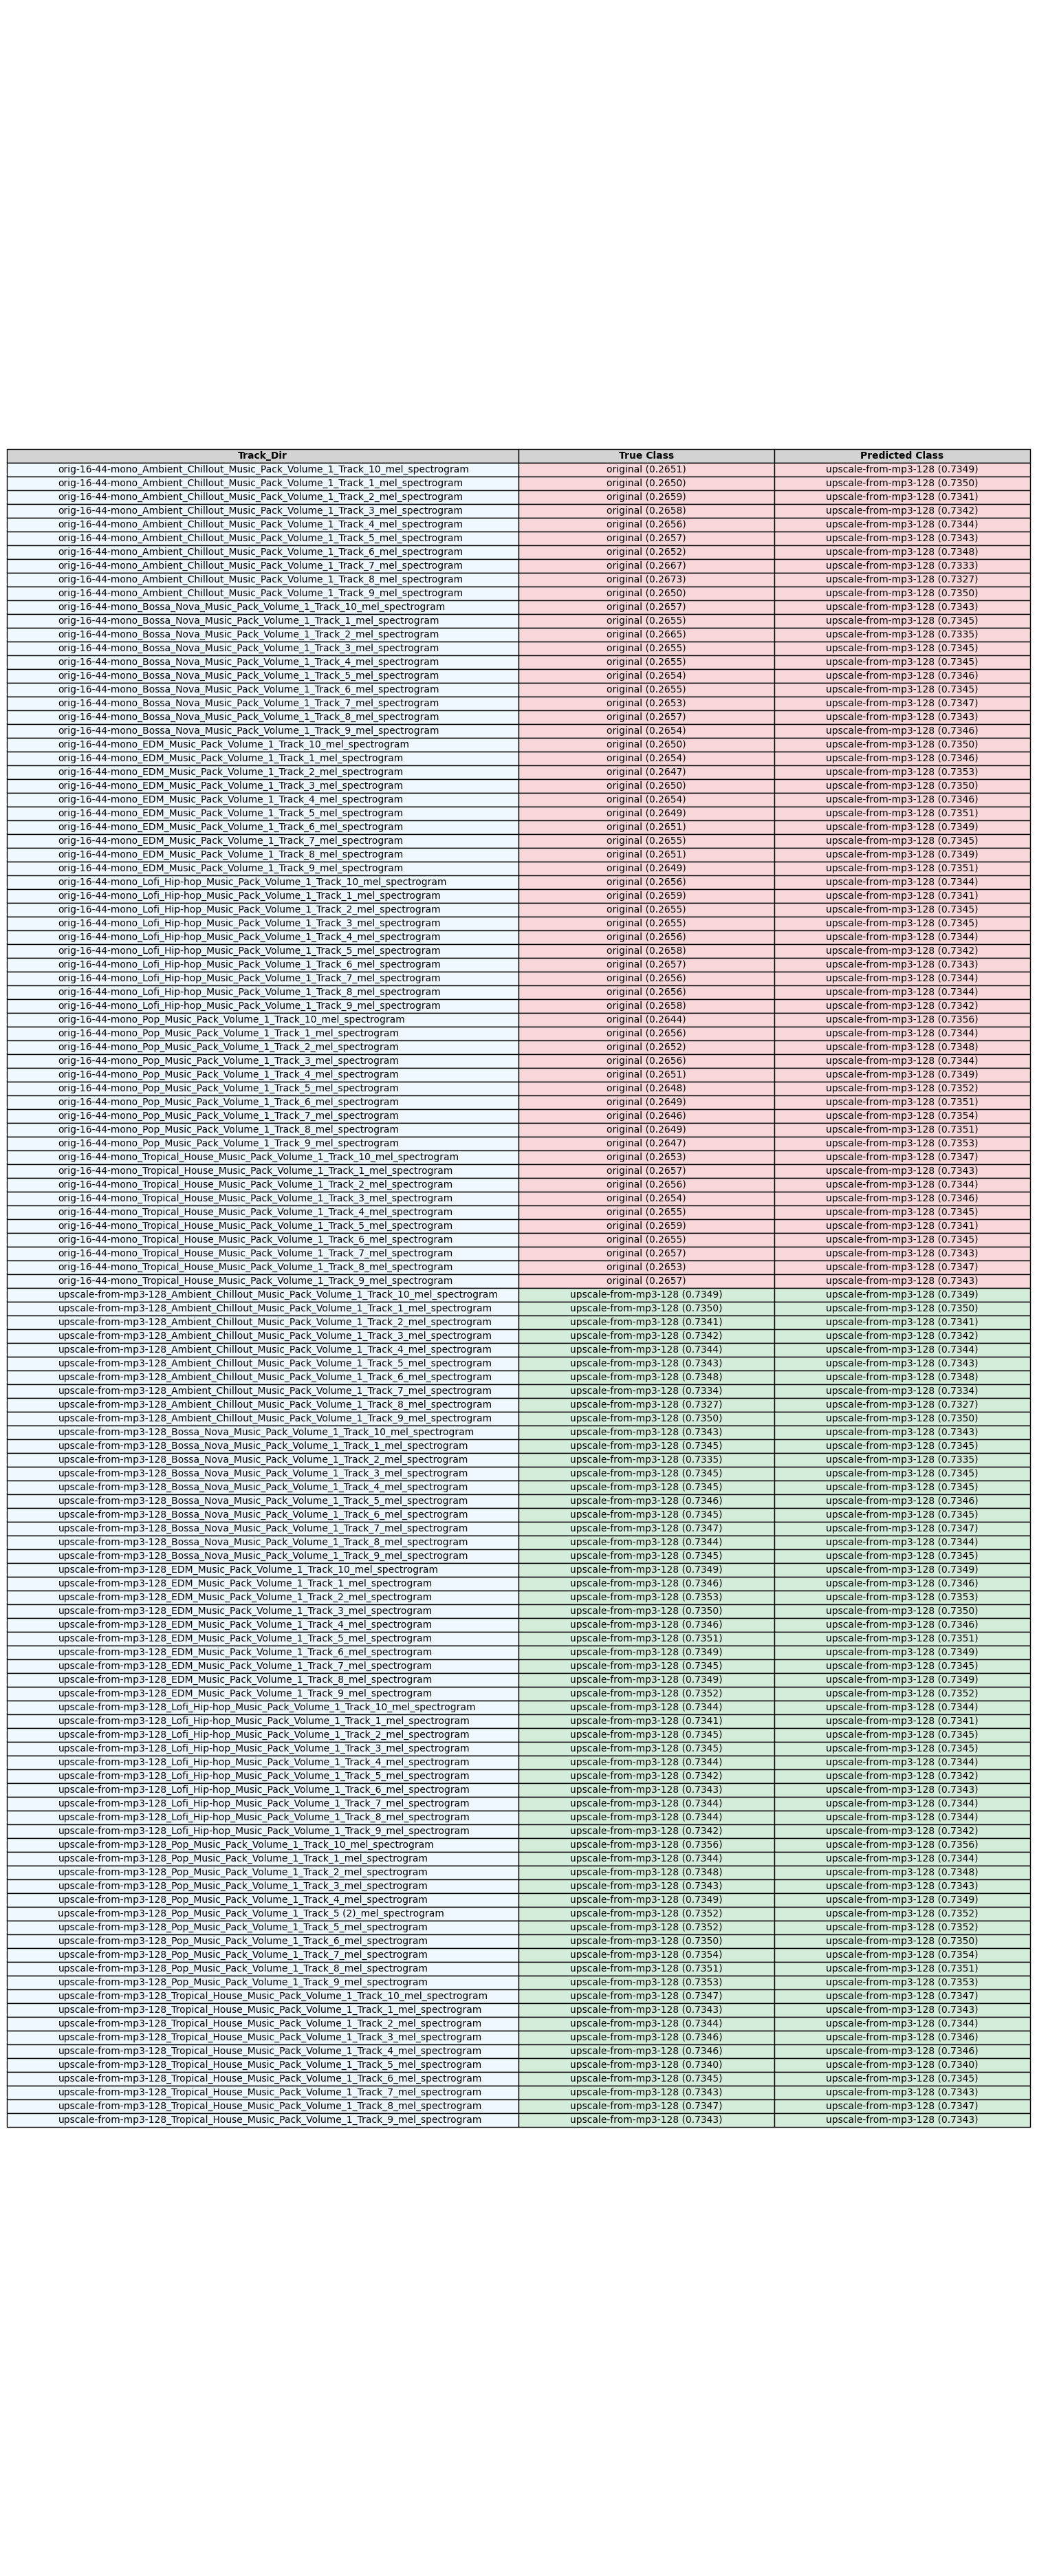

[{'Track_Dir': 'orig-16-44-mono_Ambient_Chillout_Music_Pack_Volume_1_Track_10_mel_spectrogram', 'True Class': 'original (0.2651)', 'Predicted Class': 'upscale-from-mp3-128 (0.7349)'}, {'Track_Dir': 'orig-16-44-mono_Ambient_Chillout_Music_Pack_Volume_1_Track_1_mel_spectrogram', 'True Class': 'original (0.2650)', 'Predicted Class': 'upscale-from-mp3-128 (0.7350)'}, {'Track_Dir': 'orig-16-44-mono_Ambient_Chillout_Music_Pack_Volume_1_Track_2_mel_spectrogram', 'True Class': 'original (0.2659)', 'Predicted Class': 'upscale-from-mp3-128 (0.7341)'}, {'Track_Dir': 'orig-16-44-mono_Ambient_Chillout_Music_Pack_Volume_1_Track_3_mel_spectrogram', 'True Class': 'original (0.2658)', 'Predicted Class': 'upscale-from-mp3-128 (0.7342)'}, {'Track_Dir': 'orig-16-44-mono_Ambient_Chillout_Music_Pack_Volume_1_Track_4_mel_spectrogram', 'True Class': 'original (0.2656)', 'Predicted Class': 'upscale-from-mp3-128 (0.7344)'}, {'Track_Dir': 'orig-16-44-mono_Ambient_Chillout_Music_Pack_Volume_1_Track_5_mel_spectrog

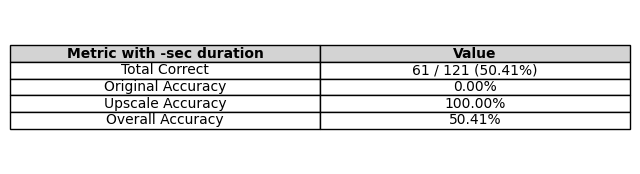

Haupttabelle als Bild gespeichert: model_results\model_(9616-resnet_model)_loss_0.452_acc_0.749_val_loss_0.41_val_acc_0.765_table.png
Zusammenfassungstabelle als Bild gespeichert: model_results\model_(9616-resnet_model)_loss_0.452_acc_0.749_val_loss_0.41_val_acc_0.765_summary.png


In [6]:

def color_table(table, df=None):
    # Tabelle verschönern: Farben hinzufügen
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Titelzeile
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#d3d3d3')  # Heller Hintergrund für die Titelzeile

        elif df is not None and i > 0 and j < len(df.columns):  # Sicherstellen, dass Spalten existieren
            if j == 0:  # Dateiname-Spalte
                cell.set_facecolor('#f0f8ff')  # Blauer Hintergrund für die Dateinamen

            elif j == 1 or j == 2:  # True Class (Spalte 1) oder Predicted Class (Spalte 2)
                true_class = df.iloc[i - 1]["True Class"]  # i-1, weil i=0 die Kopfzeile ist
                predicted_class = df.iloc[i - 1]["Predicted Class"]

                # Überprüfe, ob die Vorhersage korrekt ist
                if true_class == predicted_class:
                    cell.set_facecolor('#d4edda')  # Grün für richtig
                else:
                    cell.set_facecolor('#f8d7da')  # Rot für falsch
                cell.set_fontsize(10)

            else:  # Wahrscheinlichkeiten und andere Werte
                try:
                    if float(cell.get_text().get_text()) < 0.5:
                        cell.set_facecolor('#f8d7da')  # Rot, wenn Wahrscheinlichkeit < 0.5
                    else:
                        cell.set_facecolor('#d4edda')  # Grün, wenn Wahrscheinlichkeit >= 0.5
                except ValueError:
                    pass  # Ignoriert nicht-numerische Werte
            cell.set_fontsize(10)

    return table



def generate_summary(results):
    total_predictions = len(results)
    correct_predictions = sum(1 for result in results if result['True Class'].split()[0] == result['Predicted Class'].split()[0])  # Vergleiche nur die Klassennamen
    accuracy = correct_predictions / total_predictions * 100

    # Extrahiere die Klassennamen ohne die numerischen Werte
    correct_original = sum(1 for result in results if result['True Class'].split()[0] == 'original' and result['Predicted Class'].split()[0] == 'original')
    correct_upscale = sum(1 for result in results if result['True Class'].split()[0] == 'upscale-from-mp3-128' and result['Predicted Class'].split()[0] == 'upscale-from-mp3-128')
    
    # Berechne die Genauigkeit nur für die jeweilige Klasse, falls es Beispiele gibt
    original_accuracy = correct_original / sum(1 for result in results if result['True Class'].split()[0] == 'original') * 100 if sum(1 for result in results if result['True Class'].split()[0] == 'original') > 0 else 0
    upscale_accuracy = correct_upscale / sum(1 for result in results if result['True Class'].split()[0] == 'upscale-from-mp3-128') * 100 if sum(1 for result in results if result['True Class'].split()[0] == 'upscale-from-mp3-128') > 0 else 0

    summary = {
        "Total Correct": f"{correct_predictions} / {total_predictions} ({accuracy:.2f}%)",
        "Original Accuracy": f"{original_accuracy:.2f}%",
        "Upscale Accuracy": f"{upscale_accuracy:.2f}%",
        "Overall Accuracy": f"{accuracy:.2f}%",
    }

    return summary

# Funktion zur Erstellung der Zusammenfassungs-Tabelle
def display_summary(summary):
    summary_data = [
        ["Total Correct", summary["Total Correct"]],
        ["Original Accuracy", summary["Original Accuracy"]],
        ["Upscale Accuracy", summary["Upscale Accuracy"]],
        ["Overall Accuracy", summary["Overall Accuracy"]]
    ]

    summary_df = pd.DataFrame(summary_data, columns=[f"Metric with -sec duration", "Value"])

    fig, ax = plt.subplots(figsize=(8, 2))  # Größe der Tabelle
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc="center", loc="center", colWidths=[0.5, 0.5])
    
    color_table(table)

    plt.show()

    return fig

def calculate_accuracy(results):
    """
    Berechnet die Anzahl korrekt und falsch klassifizierter Dateien basierend auf den Ergebnissen.
    Erwartet eine Liste von Dictionaries mit den Schlüsseln 'True Class' und 'Predicted Class'.
    """
    correct_predictions = sum(1 for result in results if result['True Class'] == result['Predicted Class'])
    total_predictions = len(results)
    accuracy = correct_predictions / total_predictions * 100
    print(f"Korrekte Vorhersagen: {correct_predictions}")
    print(f"Falsche Vorhersagen: {total_predictions - correct_predictions}")
    print(f"Genauigkeit: {accuracy:.2f}%")


def save_results(zip_file_path, table_figure, summary_figure):
    # Extrahiere den Dateinamen ohne Erweiterung aus dem zip_file_path
    base_name = os.path.splitext(os.path.basename(zip_file_path))[0]
    output_dir = os.path.dirname(zip_file_path)

    # Pfade für die beiden PNG-Dateien erstellen
    table_image_path = os.path.join(output_dir, f"{base_name}_table.png")
    summary_image_path = os.path.join(output_dir, f"{base_name}_summary.png")

    # Speichern der Haupttabelle als Bild, wenn sie nicht existiert
    if not os.path.exists(table_image_path):
        table_figure.savefig(table_image_path, bbox_inches="tight")
        print(f"Haupttabelle als Bild gespeichert: {table_image_path}")
    else:
        print(f"Haupttabelle übersprungen (bereits vorhanden): {table_image_path}")

    # Speichern der Zusammenfassungstabelle als Bild, wenn sie nicht existiert
    if not os.path.exists(summary_image_path):
        summary_figure.savefig(summary_image_path, bbox_inches="tight")
        print(f"Zusammenfassungstabelle als Bild gespeichert: {summary_image_path}")
    else:
        print(f"Zusammenfassungstabelle übersprungen (bereits vorhanden): {summary_image_path}")


def load_model(zip_file_path):
    """Lädt das Modell aus einer ZIP-Datei."""
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("restored_model")
    model_path = "restored_model/model.h5"  # Pfad zur .h5-Datei
    loaded_model = tf.keras.models.load_model(model_path)
    return loaded_model



def predict_with_model(model, splits_dir):
    """
    Durchläuft alle Spektrogramm-Splits eines Tracks (Ordners),
    berechnet die Vorhersagen und gibt den Durchschnitt zurück.
    
    :param model: Das geladene Modell für die Vorhersage
    :param splits_dir: Pfad zum Ordner mit den Spektrogramm-Splits
    :return: Durchschnittliche Vorhersage für den gesamten Track
    """
    splits_dir = Path(splits_dir)
    if not splits_dir.exists() or not splits_dir.is_dir():
        raise ValueError(f"Das Verzeichnis {splits_dir} existiert nicht oder ist kein Verzeichnis.")
    
    input_shape = model.input_shape  # Erwartetes Shape (None, H, W, 3)
    _, target_height, target_width, _ = input_shape  # Extrahiere H & W
    print(f"Erwartete Bildgröße: {target_height} x {target_width}")
    
    predictions = []
    
    for image_path in splits_dir.glob("*.png"):  # Gehe durch alle Spektrogramm-Bilder
        image = Image.open(image_path).convert("RGB")  # Lade als RGB-Bild
        image = image.resize((target_width, target_height))  # Resize auf Modellgröße
        image_array = np.array(image) / 255.0  # Normalisieren auf [0, 1]
        input_data = np.expand_dims(image_array, axis=0)  # Batch-Dimension hinzufügen
        
        # Vorhersage durchführen
        pred = model.predict(input_data)[0]
        print(f"Vorhersage für {image_path}: {pred}")
        predictions.append(pred)
    
    if not predictions:
        raise ValueError(f"Keine validen Spektrogramm-Splits in {splits_dir} gefunden.")
    
    avg_prediction = np.mean(predictions, axis=0)  # Durchschnittliche Vorhersage berechnen
    print(f"Durchschnittliche Vorhersage für {splits_dir.name}: {avg_prediction}")
    
    return avg_prediction


def run(zip_file_path = "model_results/model_(9616-resnet_model)_loss_0.452_acc_0.749_val_loss_0.41_val_acc_0.765.zip"):
    extract_zip(TEST_DIR, UNZIP_DIR)
    model = load_model(zip_file_path)
    print(f"Model loaded from: {zip_file_path}")

    
    audio_dir = TEST_DIR

    path = normalize_audio_length(Path(audio_dir))
    test_mel_dir = Path(f"{path.stem}_mel_spectrograms")
    generate_mel_spectrograms_with_structure(path,test_mel_dir)
    test_mel_dir = process_spectrograms(test_mel_dir)

    results = []
    class_names = ["original", "upscale-from-mp3-128"]
    
    for track_dir in Path(test_mel_dir).iterdir():
        if track_dir.is_dir():
            if not any(track_dir.iterdir()):
                print(f"Überspringe leeres Verzeichnis: {track_dir}")
                continue
            
            # Bestimme die true_class aus dem Ordnernamen oder Metadaten
            if "orig-16-44-mono" in track_dir.name:
                true_class = "original"
            elif "upscale-from-mp3-128" in track_dir.name:
                true_class = "upscale-from-mp3-128"
            elif "upscale-from-aac-128" in track_dir.name:
                true_class = "upscale-from-aac-128"
            else:
                raise ValueError(f"Unbekannte Klasse im Ordnernamen: {track_dir.name}")
            
            predictions = predict_with_model(model, track_dir)
            predicted_class_index = np.argmax(predictions)
            predicted_class = class_names[predicted_class_index]
            class_probabilities = {class_names[i]: predictions[i] for i in range(len(predictions))}
            
            true_class_with_prob = f"{true_class} ({class_probabilities.get(true_class, 0.0):.4f})"
            predicted_class_with_prob = f"{predicted_class} ({class_probabilities[predicted_class]:.4f})"
            
            results.append({
                "Track_Dir": track_dir.name,
                "True Class": true_class_with_prob,
                "Predicted Class": predicted_class_with_prob
            })
           
    # Erstelle einen DataFrame aus den Ergebnissen
    df = pd.DataFrame(results)

    # print (df)
    
    fig, ax = plt.subplots(figsize=(16, len(df) * 0.4))  # Breitere Tabelle für längere Dateinamen
    ax.axis('tight')
    ax.axis('off')

    # Formatieren der Zellen als Strings mit 4 Dezimalstellen
    cell_text = [
        [str(value) if isinstance(value, str) else f"{value:.4f}" for value in row]
        for row in df.values
    ]

    # Dynamische Anpassung der Spaltenbreiten
    table = ax.table(
        cellText=cell_text,
        colLabels=df.columns,
        cellLoc="center",
        loc="center",
        colWidths=[0.5] + [0.25] * (len(df.columns) - 1)
    )
    
    for row in range(len(df)):
        cell = table[(row + 1, 0)]
        cell.get_text().set_ha('left')

    table = color_table(table, df)

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2) 
    plt.show()

    
    print(results)
    summary = generate_summary(results)
    summary_figure = display_summary(summary)

    save_results(zip_file_path, fig, summary_figure)
    shutil.rmtree("restored_model")


run()